In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LeakyReLU
from keras import backend
import scipy.stats

In [2]:
# Synthetic data
import random

syn_data = pd.DataFrame(columns=['Close', 'Maturity', 'Div_Yield', 'iv_current', 'RF', "Strike"]) 

syn_data.Close = [round(random.uniform(10, 500),2) for _ in range(300000)]
syn_data.Strike = [round(random.uniform(7, 650),2) for _ in range(300000)]
syn_data.Maturity = [round(random.uniform(1, 1.095),2) for _ in range(300000)]
syn_data.Div_Yield = [round(random.uniform(0, 0.03),2) for _ in range(300000)]
syn_data.RF = [round(random.uniform(0.01, 0.03),2) for _ in range(300000)]
syn_data.iv_current = [round(random.uniform(0.05, 0.9),2) for _ in range(300000)]

In [3]:
syn_data

,Close,Maturity,Div_Yield,iv_current,RF,Strike
0,220.82,1.05,0.02,0.48,0.01,629.39
1,81.64,1.06,0.03,0.47,0.02,164.66
2,39.33,1.06,0.02,0.14,0.02,370.32
3,281.23,1.03,0.02,0.69,0.02,625.49
4,249.97,1.07,0.01,0.31,0.03,120.52
...,...,...,...,...,...,...
299995,206.66,1.03,0.02,0.72,0.02,330.97
299996,414.26,1.06,0.02,0.47,0.01,511.45
299997,97.52,1.06,0.03,0.78,0.02,255.77
299998,380.51,1.00,0.01,0.28,0.01,537.96


In [4]:
d_1 = (np.log(syn_data.Close/syn_data.Strike) + (syn_data.RF - syn_data.Div_Yield - 0.5*syn_data.iv_current)*syn_data.Maturity)/ np.sqrt(syn_data.iv_current)*np.sqrt(syn_data.Maturity)

In [5]:
d_2 = d_1 - (np.sqrt(syn_data.iv_current)*np.sqrt(syn_data.Maturity))

In [6]:
syn_data["Call Price"] = syn_data.Close * np.exp(-syn_data.Div_Yield*syn_data.Maturity) * scipy.stats.norm.pdf(d_1) - syn_data.Strike * np.exp(-syn_data.RF*syn_data.Maturity) * scipy.stats.norm.pdf(d_2)

In [7]:
syn_data.describe()

,Close,Maturity,Div_Yield,iv_current,RF,Strike,Call Price
count,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000
mean,254.847191,1.047327,0.015024,0.474744,0.020001,328.556881,22.686298
std,141.508517,0.027440,0.009581,0.245355,0.007061,185.553640,25.700001
min,10.000000,1.000000,0.000000,0.050000,0.010000,7.000000,-0.006853
25%,132.130000,1.020000,0.010000,0.260000,0.020000,168.070000,1.122363
50%,254.700000,1.050000,0.020000,0.470000,0.020000,328.630000,12.583795
75%,377.680000,1.070000,0.020000,0.690000,0.020000,489.410000,37.248138
max,500.000000,1.090000,0.030000,0.900000,0.030000,650.000000,122.541694


In [8]:
syn_data["Close"] = syn_data["Close"]/syn_data["Strike"]
syn_data["Call Price"] = syn_data["Call Price"]/syn_data["Strike"]

In [9]:
#n = 300000
#n_train =  (int)(0.8 * n)
#train = appl_options[0:n_train]
#X_train = train[['Close', 'Maturity', 'Div_Yield', 'iv_current', 'RF']].values
#y_train = train['bid'].values
#test = appl_options[n_train+1:n]
#X_test = test[['Close', 'Maturity', 'Div_Yield', 'iv_current', 'RF']].values
#y_test = test['bid'].values

In [10]:
n = 300000
n_train =  (int)(0.8 * n)
train = syn_data[0:n_train]
X_train = train[['Close', 'Maturity', 'Div_Yield', 'iv_current', 'RF']].values
y_train = train['Call Price'].values
test = syn_data[n_train+1:n]
X_test = test[['Close', 'Maturity', 'Div_Yield', 'iv_current', 'RF']].values
y_test = test['Call Price'].values

In [11]:
def custom_activation(x):
    return backend.exp(x)

In [12]:
nodes = 120
model = Sequential()

model.add(Dense(nodes, input_dim=X_train.shape[1]))
model.add(LeakyReLU())
model.add(Dropout(0.25))

model.add(Dense(nodes, activation='elu'))
model.add(Dropout(0.25))

model.add(Dense(nodes, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(nodes, activation='elu'))
model.add(Dropout(0.25))

model.add(Dense(1))
model.add(Activation(custom_activation))
          
model.compile(loss='mse',optimizer='rmsprop')

In [13]:
model.fit(X_train, y_train, batch_size=64, epochs=10, validation_split=0.1, verbose=2)

Epoch 1/10
3375/3375 - 5s - loss: 0.0016 - val_loss: 1.9331e-04
Epoch 2/10
3375/3375 - 5s - loss: 4.4033e-04 - val_loss: 5.8044e-05
Epoch 3/10
3375/3375 - 4s - loss: 3.5199e-04 - val_loss: 2.8395e-04
Epoch 4/10
3375/3375 - 5s - loss: 3.0387e-04 - val_loss: 8.8879e-05
Epoch 5/10
3375/3375 - 5s - loss: 2.6952e-04 - val_loss: 1.1171e-04
Epoch 6/10
3375/3375 - 5s - loss: 2.3987e-04 - val_loss: 1.1096e-04
Epoch 7/10
3375/3375 - 5s - loss: 2.2245e-04 - val_loss: 8.2136e-05
Epoch 8/10
3375/3375 - 5s - loss: 2.0814e-04 - val_loss: 4.6525e-05
Epoch 9/10
3375/3375 - 5s - loss: 2.0092e-04 - val_loss: 1.2272e-04
Epoch 10/10
3375/3375 - 4s - loss: 1.9497e-04 - val_loss: 5.9127e-05


In [14]:
def CheckAccuracy(y,y_hat):
    stats = dict()
    
    stats['diff'] = y - y_hat
    
    stats['mse'] = np.mean(stats['diff']**2)
    print("Mean Squared Error:      ", stats['mse'])
    
    stats['rmse'] = np.sqrt(stats['mse'])
    print("Root Mean Squared Error: ", stats['rmse'])
    
    stats['mae'] = np.mean(abs(stats['diff']))
    print("Mean Absolute Error:     ", stats['mae'])
    
    stats['mpe'] = np.sqrt(stats['mse'])/np.mean(y)
    print("Mean Percent Error:      ", stats['mpe'])
    
    #plots
    plt.rcParams['agg.path.chunksize'] = 100000
    #figure(figsize=(14,10))
    plt.scatter(y, y_hat,color='black',linewidth=0.3,alpha=0.4, s=0.5)
    plt.xlabel('Actual Price',fontsize=20,fontname='Times New Roman')
    plt.ylabel('Predicted Price',fontsize=20,fontname='Times New Roman') 
    plt.show()
    
    #figure(figsize=(14,10))
    plt.hist(stats['diff'], bins=50,edgecolor='black',color='white')
    plt.xlabel('Diff')
    plt.ylabel('Density')
    plt.show()
    
    return stats

Mean Squared Error:       5.7919280151793046e-05
Root Mean Squared Error:  0.007610471743052007
Mean Absolute Error:      0.0038408813348407753
Mean Percent Error:       0.08165591519308715


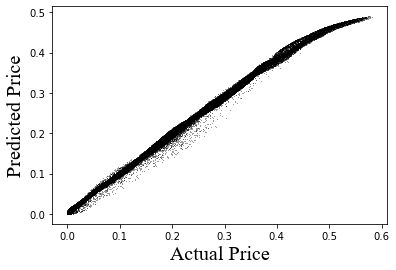

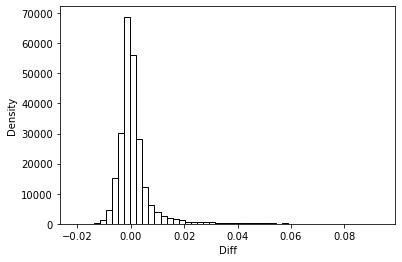

{'diff': array([ 2.31243312e-03,  1.37824317e-03, -7.86960944e-05, ...,
         1.73081946e-03, -3.52962108e-04,  1.68232066e-04]),
 'mse': 5.7919280151793046e-05,
 'rmse': 0.007610471743052007,
 'mae': 0.0038408813348407753,
 'mpe': 0.08165591519308715}

In [15]:
y_train_hat = model.predict(X_train)
#reduce dim (240000,1) -> (240000,) to match y_train's dim
y_train_hat = np.squeeze(y_train_hat)
CheckAccuracy(y_train, y_train_hat)

In [16]:
np.mean(y_train_hat)

0.09208633

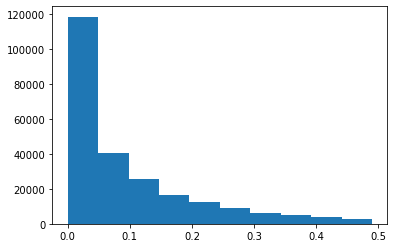

In [17]:
plt.hist(y_train_hat, bins=10)
plt.show()